# Import the Model

In [1]:
import tensorflow as tf

from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

In [3]:
model.trainable = False

In [4]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#Import Libraries and Helper Functions

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

# Image Processing and Display

In [6]:
def load_and_process_image(image_path):
  img = load_img(image_path)
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis = 0)
  return img

In [7]:
def deprocess(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 116.799
  x[:,:,2] += 123.68
  x = x[:,:,::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [8]:
def display_image(image):
  if len(image.shape) == 4:
    image = np.squeeze(image, axis = 0)
  img = deprocess(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  return 

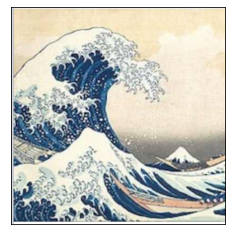

In [9]:
display_image(load_and_process_image('wave.png'))

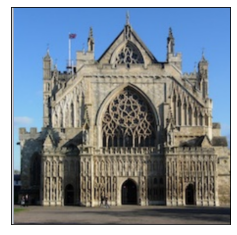

In [10]:
display_image(load_and_process_image('content.jpg'))

# Content and Style Models

In [11]:
content_layer = 'block5_conv2'

style_layers = [
                'block1_conv1',
                'block3_conv1',
                'block5_conv1'
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)


style_models = [ Model(inputs = model.input,
                       outputs = model.get_layer(layer).output) for layer in style_layers]


#Content Cost

In [12]:
def content_cost(content, generated):
  a_C = content_model(content)
  a_G = content_model(generated)
  cost = tf.reduce_mean( tf.square( a_C - a_G))
  return cost

#Gram Matrix

In [13]:
def gram_matrix(A):
  n_C = int( A.shape[-1] )
  a = tf.reshape(A, [-1, n_C])
  n = tf.shape(a)[0]
  G = tf.matmul(a, a, transpose_a=True)
  return G / tf.cast(n, tf.float32)

#Style Cost

In [14]:
lam = 1. / len(style_models)

def style_cost( style, generated):
  j_style = 0

  for style_model in style_models:
    a_S = style_model(style)
    a_G = style_model( generated)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    current_cost = tf.reduce_mean( tf.square( GS - GG))
    j_style += current_cost*lam
  return j_style

#Training Loop

In [15]:
import time

generated_images = []


def training_loop( content_path, style_path, iterations = 20,
                  alpha = 10, beta = 20):
  content = load_and_process_image( content_path)
  style = load_and_process_image(style_path)
  generated = tf.Variable(content, dtype = tf.float32)
  opt = tf.keras.optimizers.Adam(learning_rate = 7.)
  best_cost = 1e12 + 0.1
  best_image = None
  start_time = time.time()

  for i in range(iterations):
    with tf.GradientTape() as tape:
      J_content = content_cost( content, generated)
      J_style = style_cost( style, generated)
      J_total = alpha* J_content + beta* J_style
    grads = tape.gradient(J_total, generated)
    opt.apply_gradients([(grads, generated)])

    if J_total < best_cost:
      best_cost = J_total
      best_image = generated.numpy()

    print("Cost at {}: {}. Time elapsed: {}".format(i, J_total, time.time() - start_time))
    generated_images.append(generated.numpy())
  return best_image

In [16]:
best_image = training_loop('content.jpg','wave.png')

Cost at 0: 2350740224.0. Time elapsed: 2.5079522132873535
Cost at 1: 1266734464.0. Time elapsed: 2.7414097785949707
Cost at 2: 957354880.0. Time elapsed: 2.9782121181488037
Cost at 3: 795323008.0. Time elapsed: 3.209998607635498
Cost at 4: 679924352.0. Time elapsed: 3.4421544075012207
Cost at 5: 583606656.0. Time elapsed: 3.6748714447021484
Cost at 6: 508550816.0. Time elapsed: 3.906649351119995
Cost at 7: 452868096.0. Time elapsed: 4.138886213302612
Cost at 8: 405075552.0. Time elapsed: 4.370790958404541
Cost at 9: 366003136.0. Time elapsed: 4.602832794189453
Cost at 10: 334993248.0. Time elapsed: 4.834413766860962
Cost at 11: 308775968.0. Time elapsed: 5.068012237548828
Cost at 12: 286448064.0. Time elapsed: 5.300195932388306
Cost at 13: 267257168.0. Time elapsed: 5.532489538192749
Cost at 14: 250287408.0. Time elapsed: 5.764408349990845
Cost at 15: 234847984.0. Time elapsed: 5.997080326080322
Cost at 16: 220381280.0. Time elapsed: 6.230642557144165
Cost at 17: 207438640.0. Time elap

# Plot the Result

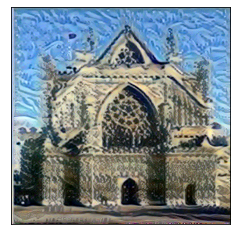

In [17]:
display_image(best_image)

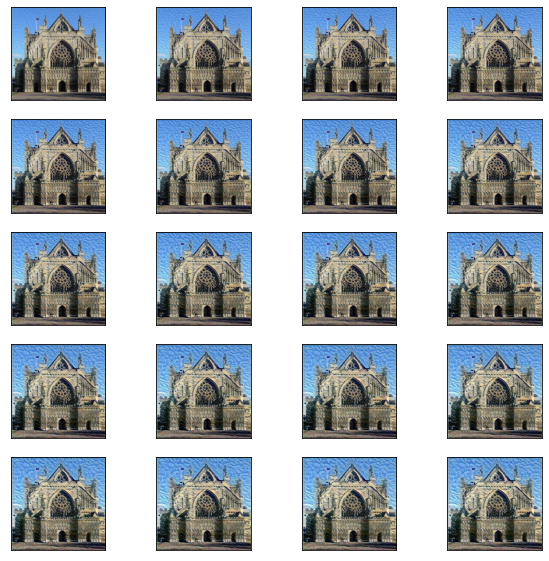

In [18]:
plt.figure(figsize=(10,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  display_image(generated_images[i])
plt.show()